In [1]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import calc_class_weights
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.report import Reports
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR
from pyecg.utils import sig_similarity_report,sig_similarity_hist
from pyecg.data_handling import slice_data
from pyecg.data_rpeak import *


reset_seed() 

2022-06-25 00:38:23.014354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 00:38:23.014393: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-25 00:38:36.860862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 00:38:36.860936: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 00:38:36.860995: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-25 00:38:36.883349: I tensorflow/core/platform/cpu_feature_gua

# Proto

In [2]:
datasets = {1:'raw_rpeak'}
models = {1:'rpeak3'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['model'] = models[1]
CONFIG['model_type'] = 'CLF' #CLF or AE
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = None #{'N':0} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = None      #'zscore' 'minmax' , None, 'max' 

# Data

In [3]:
#Load data 
if CONFIG['dataset'] == 'raw_rpeak': 
    annotated_records, samples_info = load_data(file_path = '../data/DS1_samples.rpeak')

File loaded: ../data/DS1_samples.rpeak


In [4]:
samples_info[0][2]-samples_info[0][1]  #win size 

10800

In [5]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)
np.unique(labels,return_counts=True)

(array([0, 1]), array([4355824, 1504976]))

In [6]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)

39072

In [7]:
class_labels,counts = list(np.unique(labels,return_counts=True))
class_labels,counts

(array([0, 1]), array([4355824, 1504976]))

In [8]:
len(annotated_records[0][0]) #signal length

650000

In [9]:
np.unique(labels,return_counts=True)

(array([0, 1]), array([4355824, 1504976]))

# Train

In [10]:
if CONFIG['model'] == 'rpeak3':
    from pyecg.models.rpeak3 import model_arch 

In [11]:
params_model = {
    'x_input_dim' : samples_info[0][2]-samples_info[0][1],  #win size
    'out_seq_len' : len(labels[0]),
    'num_classes' : len(np.unique(labels)),
    'regularizer' : None
}
params_train = {
    'batch_size' : 128,
    'epochs' : 1
} 

In [12]:
params_model

{'x_input_dim': 10800,
 'out_seq_len': 150,
 'num_classes': 2,
 'regularizer': None}

In [13]:
params_model['num_classes']=14

In [14]:
mymodel = model_arch(params_model)                                          


Layer: X_INPUT_DIM -->  Output shape: [None, 10800]

Layer: TF.EXPAND_DIMS/EXPANDDIMS:0 -->  Output shape: [None, 10800, 1]

Layer: BATCH_NORMALIZATION/BATCHNORM/ADD_1:0 -->  Output shape: [None, 10800, 1]

Layer: MAX_POOLING1D/SQUEEZE:0 -->  Output shape: [None, 75, 16]

Layer: MAX_POOLING1D/SQUEEZE:0 -->  Output shape: [None, 75, 16]

Layer: DROPOUT_1/IDENTITY:0 -->  Output shape: [None, 75, 256]

Layer: DENSE_1/SOFTMAX:0 -->  Output shape: [None, 75, 14]


In [15]:
mymodel.summary()

Model: "Model_Conv1d_Rpeak"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_input_dim (InputLayer)    [(None, 10800)]           0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 10800, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 10800, 1)         4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 10800, 16)         592       
                                                                 
 batch_normalization_1 (Batc  (None, 10800, 16)        64        
 hNormalization)                                                 
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 10800, 16)  

In [16]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [17]:
def my_log_loss(y_true, y_pred):
    squared_difference = tf.square(tf.math.log(y_true + 5) - tf.math.log(y_pred + 5))
    return tf.reduce_mean(squared_difference, axis=-1) 

In [18]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

def get_loss(model_type):
    if model_type == 'AE':
        loss = "mse"
        #loss = 'binary_crossentropy'
        #loss='mean_squared_logarithmic_error'
        #loss = my_log_loss
        #loss = 'cosine_similarity'
    else:
        #loss = "binary_crossentropy"
        loss = "sparse_categorical_crossentropy"
        #loss=SparseCategoricalFocalLoss(gamma=3)
    return loss

def get_metrics(model_type):
    if model_type == 'AE':
        metrics = None
    else:
        metrics = ['accuracy']
    return metrics
    

mymodel.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None
              )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)
import time
batch_sleep = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs: time.sleep(.0001))

callbacks = [early_stopping, model_checkpoint, reduce_lr, batch_sleep]  
callbacks = [batch_sleep]  

rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [19]:
class_labels = []
for rec in annotated_records:
    lb = np.unique(rec[1])
    class_labels.extend(lb.tolist())
class_labels = list(set(class_labels))

In [20]:
class_labels

['j', 'L', 'a', 'R', 'Q', 'E', 'e', '0', 'N', 'A', 'F', 'S', 'J', 'V']

In [21]:
bnry_ = False
cl_ = list(class_labels) #None
interval = 144
train_generator = ECGSequence(annotated_records,
                              samples_info,
                              batch_size=params_train['batch_size'],
                              binary=bnry_,
                              raw=True,
                              interval=interval,
                              class_labels=cl_
                              )
#train_generator.__getitem__(0)[0].shape

In [22]:
train_generator.__getitem__(0)[0].shape, train_generator.__getitem__(0)[1].shape

((128, 10800), (128, 75))

In [23]:
np.unique(train_generator.__getitem__(0)[1],return_counts=True)

(array([ 0,  1,  2,  3,  7,  8,  9, 10, 11, 12, 13]),
 array([   1,  355,   35,  216, 4674, 3661,   60,   84,    2,    1,  511]))

In [39]:
%%time
#%%prun -s cumulative

#model fitting
model_history = mymodel.fit_generator(generator=train_generator,
                                    #validation_data=validation_generator,
                                    use_multiprocessing=True,
                                    #workers=2,
                                    epochs=params_train['epochs'],
                                    verbose=1,
                                    callbacks=callbacks
                                     )


<timed exec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


306/306 [==============================] - 528s 2s/step - loss: 0.0707 - accuracy: 0.9818
CPU times: user 25min 43s, sys: 4min, total: 29min 43s
Wall time: 8min 48s


In [40]:
#mymodel.predict(train_generator.__getitem__(0)[0])

In [41]:
#plot_loss(model_history) 

import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)

a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

# Loading Model

In [42]:
#loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
#mymodel = tf.keras.models.load_model(BASEPATH+'saved_models/mymodel')
loaded_model = mymodel
loaded_model.name 
#loaded_model.summary() 

'Model_Conv1d_Rpeak'

In [43]:
#Load Test Set
#Load data
if CONFIG['dataset'] == 'raw_rpeak': 
    annotated_records_test, samples_info_test = load_data(file_path = '../data/DS2_samples.rpeak')

File loaded: ../data/DS2_samples.rpeak


In [44]:
len(samples_info_test)

1320

In [45]:
labels=[]
for sample in samples_info_test:
    labels.append(sample[3])
len(labels)

np.unique(labels,return_counts=True)

(array([0, 1]), array([148445,  49555]))

In [46]:
#Test generator
batch_size=128
test_generator = ECGSequence(annotated_records_test,
                              samples_info_test,
                              batch_size=batch_size,
                              binary=bnry_,
                              raw=True,
                              interval=interval,
                              class_labels=cl_
                            )

In [47]:
labels_true=[]
labels_pred = []
for i in range(round(len(samples_info_test)/batch_size)): 
    samples = test_generator.__getitem__(i)
    
    labels_true.extend(samples[1])
    probs = loaded_model.predict_generator(samples[0])
    labels_pred.extend(list(np.argmax(probs,axis=-1)))

labels_true = np.array(labels_true)
labels_pred = np.array(labels_pred)
assert labels_true.shape == labels_pred.shape

/tmp/ipykernel_7761/3851531521.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probs = loaded_model.predict_generator(samples[0])


In [48]:
if cl_:
    labels_true = np.array([class_labels[i] for i in labels_true.flatten()])
    labels_pred = np.array([class_labels[i] for i in labels_pred.flatten()])

In [49]:
min(probs.flatten()), max(probs.flatten())

(2.6407116e-26, 0.99999994)

In [50]:
labels_true.shape

(96000,)

In [51]:
np.unique(labels_pred),np.unique(labels_true) 

(array(['0', 'A', 'E', 'F', 'N', 'R', 'V', 'a'], dtype='<U1'),
 array(['0', 'A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'V', 'a', 'j'],
       dtype='<U1'))

In [52]:
if CONFIG['model_type'] == 'CLF':
    from sklearn.metrics import confusion_matrix, classification_report
    true = labels_true.flatten() 
    pre = labels_pred.flatten() 
    print(classification_report(true, pre))
    print(confusion_matrix(true, pre)) 

/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     47974
           A       0.41      0.00      0.01      1695
           E       0.00      0.00      0.00         1
           F       0.89      0.04      0.08       387
           J       0.00      0.00      0.00        50
           L       0.00      0.00      0.00      3981
           N       0.77      0.98      0.86     35184
           Q       0.00      0.00      0.00         7
           R       0.00      0.00      0.00      3399
           V       0.91      0.66      0.77      3082
           a       0.03      0.18      0.06        45
           j       0.00      0.00      0.00       195

    accuracy                           0.88     96000
   macro avg       0.33      0.24      0.23     96000
weighted avg       0.81      0.88      0.84     96000

[[47651     0     0     0     0     0   248     0     0    75     0     0]
 [   37     7     0     0     0     0  1645     0     0   

/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# misclassified

/tmp/ipykernel_7761/1219659836.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probs = loaded_model.predict_generator(samples[0])
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


180
181
182
183
184


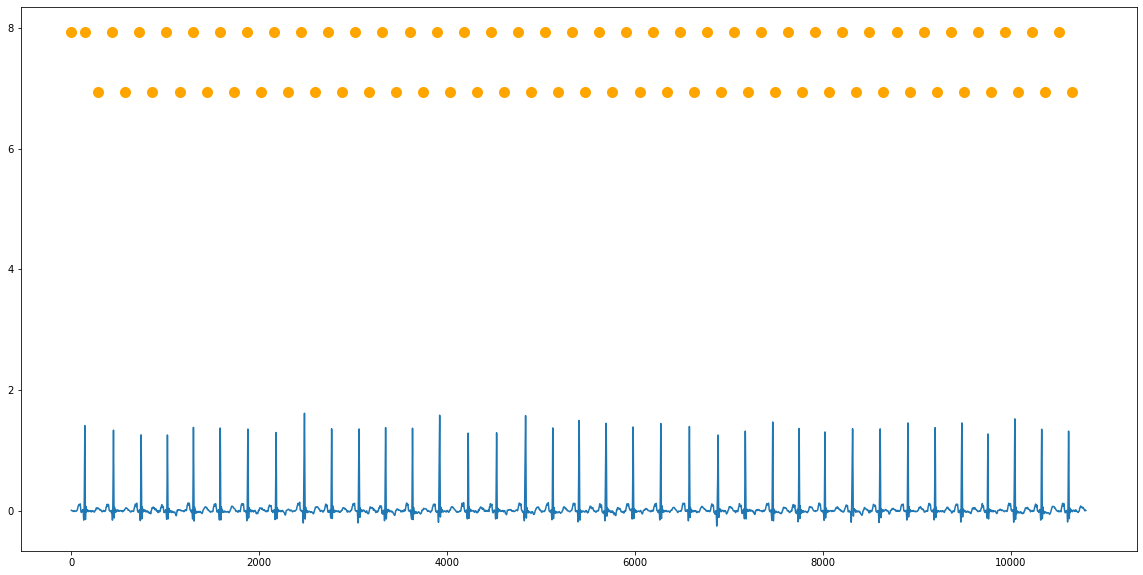

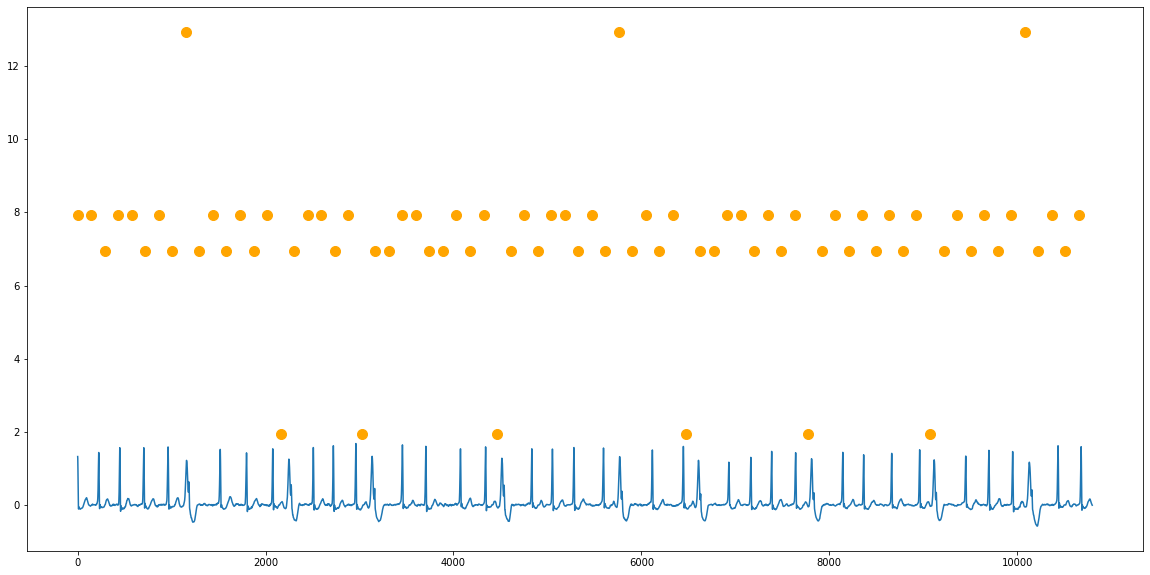

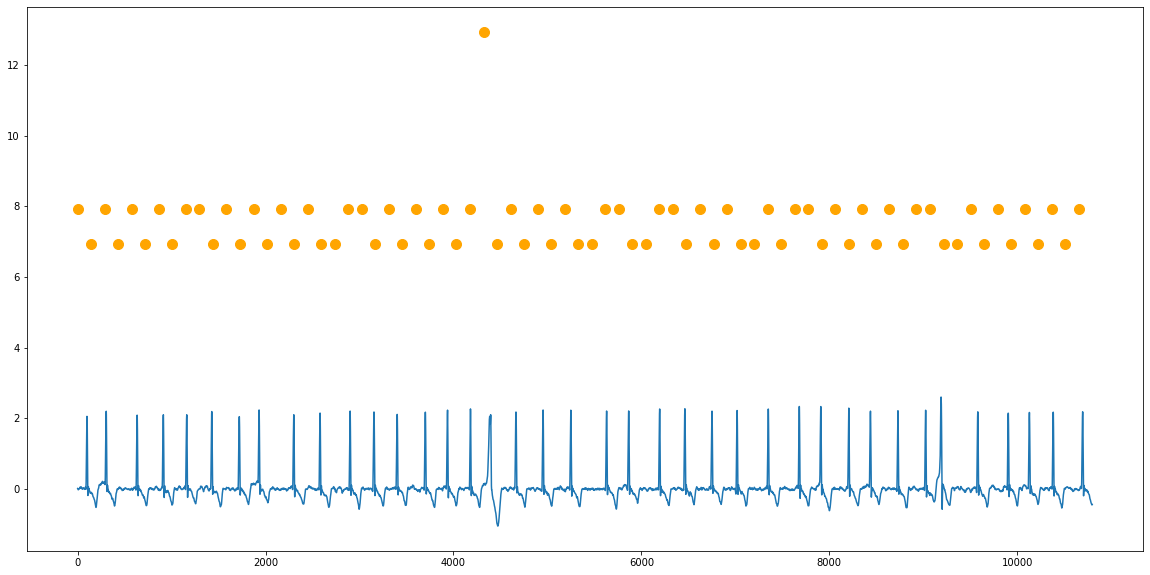

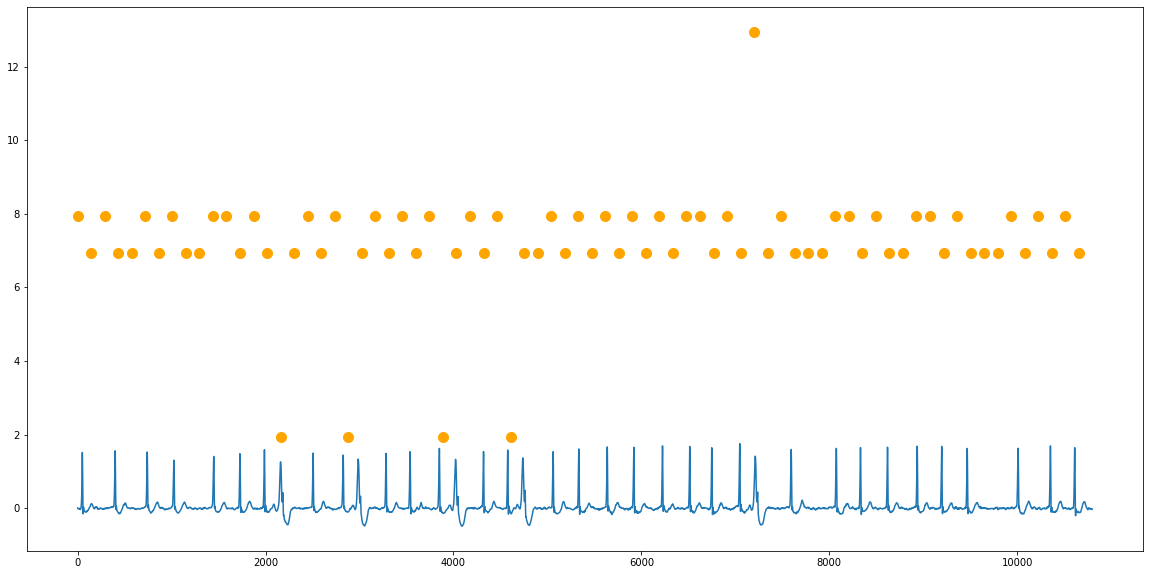

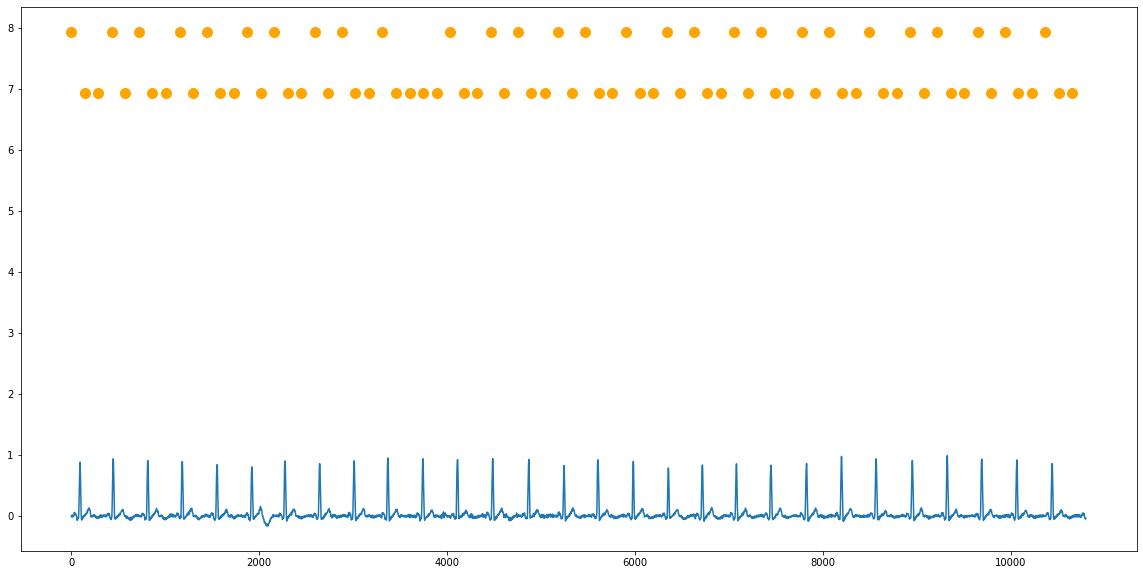

In [53]:
#Test generator
batch_size=1

labels_true=[]
labels_pred = []
for i in range(180,185):   #range(round(len(samples_info_test)/batch_size)): 
    test_generator = ECGSequence(annotated_records_test,
                                  [samples_info_test[i]],
                                  batch_size=batch_size,
                                  binary=bnry_,
                                  raw=True,
                                  interval=interval
                                  #class_labels=cl_)
                                )
    samples = test_generator.__getitem__(0)
    
    labels_true=samples[1]
    probs = loaded_model.predict_generator(samples[0])
    labels_pred = np.argmax(probs,axis=-1)

    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    if not np.array_equal(labels_true,labels_pred):
        print(i)
        #print(labels_true)
        #print(labels_pred)
        rec = samples_info_test[i][0]
        st = samples_info_test[i][1]
        en = samples_info_test[i][2]
        
        sig = annotated_records_test[rec][0][st:en]
        plt.figure(figsize=(20,10))
        plt.plot(sig)
        for p in range(labels_true.shape[1]):
            if labels_true[0][p]==1:
                plt.scatter(p*interval,labels_true[0][p],s=100,c='g')
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p]==1:
                plt.scatter(p*interval,labels_pred[0][p]-.03,s=100,c='r')
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p]!=labels_true[0][p]:
                plt.scatter(p*interval,labels_pred[0][p]-.06,s=100,c='orange')
        